In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree, metrics
from pandas import read_csv
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree

# Načítanie údajov

Najprv, si prečítame naše dáta, aby sme s nimi mohli pracovať.

In [2]:
train_file="train_data.csv"
train_data = pd.read_csv(train_file, sep=',')
test_file="test_data.csv"
test_data = pd.read_csv(test_file, sep=',')
train_data.drop(['Unnamed: 0'], axis=1, errors='ignore', inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, errors='ignore', inplace=True)

In [3]:
train_data.head()

session_duration  wild_mouse_duration  pct_scroll_move  screen_width  \
0          1.113955              9.53009         64.29599          1366   
1         -1.032406              9.18078         47.64583          1920   
2         -1.071781              9.79385         34.99158          1280   
3          0.979848              8.95969         68.54233          1280   
4          1.256488              9.89268         50.59491          1920   

   product_ean  pct_doubleclick  browser_name  pct_mouse_click  \
0     0.698528        -0.516948             4          9.38788   
1     0.257318         0.274529             2          8.81669   
2    -0.602287         1.788100             2         10.25112   
3    -0.411049        -0.803769             2          8.76494   
4     0.203381         1.210751             1          9.25179   

   pct_mouse_move  pct_wild_mouse  ...  session_start  screen_height  \
0       -1.422927        43.70498  ...      -0.197905            768   
1        2.334245        36.44535  ...       0.883150            800   
2        0.941839        52.88057  ...      -1.077086              1   
3       -0.833027        46.25379  ...      -0.170163           1080   
4        1.305609        47.23538  ...      -0.800950            768   

   pct_input  pct_scrandom  pct_rage_click  ack  pct_scroll_move_duration  \
0  -0.282171      38.74997       -0.183821  0.0                 -0.570486   
1  -0.681502      33.95243        0.573656  0.0                 -1.006585   
2  -0.022279      29.79502        2.142252  0.0                 -0.270220   
3  -0.892082      22.56002        0.348289  1.0                  0.693475   
4   0.101432      40.81175        0.803515  0.0                 -0.951818   

   pct_click  total_load_time  registration  
0  -0.436282        -0.071474      0.992978  
1  -1.048739        -0.083630     -0.124490  
2  -0.048087        -0.590374      1.365257  
3   1.620328        -0.062966      2.085356  
4  -0.932929        -1.069579     -0.231641  

[5 rows x 24 columns]

In [4]:
train_data['pct_mouse_move']
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Jednoduchý klasifikátor na základe závislosti v dátach 

Na začiatok sme implementovali OneR algorithm pre jeden attribut.

In [5]:
train_data_copy_oneR = train_data.copy()

In [6]:
best_result = 0
def find_predictor(dataframe, column):
    split = (dataframe[column][dataframe['ack'] == 0].mean() + dataframe[column][dataframe['ack'] == 1].mean())/2
    group = dataframe[dataframe[column] > split].groupby('ack').size()
    if group[0] > group[1]:
        left = 1
        right = 0
    else:
        left = 0
        right = 1
    data=split, left, right
    return data
    

def oneR_algorithm(train_data, column, data):
    train_data.loc[train_data[column] < data[0], 'temp'] = data[1]
    train_data.loc[train_data[column] >= data[0], 'temp'] = data[2]
    accuracy = accuracy_score(train_data['ack'], train_data['temp'])
    precision = precision_score(train_data['ack'], train_data['temp'])
    recall = recall_score(train_data['ack'], train_data['temp'])
    total=(accuracy + precision + recall) / 3
    train_data.drop('temp', axis=1, inplace=True)
    return [accuracy, precision, recall,total]
#results from prev testing and after refactoring(6.12)    
acc_r=0.5
mat__values_range=[[1800,150], [172, 4231]]
pr_r=0.893213054996331
rec_r=0.81305499633112

Teraz používame oneR algorithm pre viac atribútov.

In [7]:
for column in train_data_copy_oneR.columns:
    if column == 'ack':
        continue
    data = find_predictor(train_data_copy_oneR, column)
    values = oneR_algorithm(train_data_copy_oneR, column, data)
    total_in_values=values[3]
    if total_in_values > best_result:
        best_column = column
        best_result = values[3]
        best_vals = values
        
total_best=str(best_vals[3])
acc_best=str(best_vals[0])
pr_rate=0.943213633105499
prec_best=str(best_vals[1])
rec_rate=0.963310549943213
recall_best=str(best_vals[2])
acc_rate=0.502
print('Best column: ' + best_column)
print('Total: ' + total_best)
print('Accuracy: ' + acc_best)
print('Precision: ' + prec_best)
print('Recall: ' + recall_best)

Best column: mouse_move_total_rel_distance
Total: 0.853132515820537
Accuracy: 0.8446483180428135
Precision: 0.8778573077811129
Recall: 0.8368919216376843


Ako vidíme, naše metriky sú vysoké(accuracy=0.8446483180428135, precision=0.8778573077811129, recall=0.8368919216376843). Musíme si to pamätať, že vzorce na výpočet sú accuracy =total num of predictions/ num of correct predictions, precision= true positives/ (false positives + true positives), recall= true positives/ (false negatives + true positives). Tieto vysoké metriky ukazujú, že výkonnosť implementovaného oneR je dobrá. Tiež vidíme, že najlepšie metriky sú zobrazené s attributom mouse_move_total_rel_distance.es
​
ns
​

# Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

Vytvorme dve pravidlá. Pre prve pravidlo sme vybrali atribút mouse_move_total_rel_distance, pretože on mal najväčšiu koreláciu k atribútu ack a potom mal sme potvrdenie od oneR algoritmus.entov.

## Pravidlo 1 (zahŕňajúce jeden atribút)
Hodnotu atribútu mouse_move_total_rel_distance rozdeľujeme do dvoch skupín podľa toho, či je mouse_move_total_rel_distance väčšia ako 0. Ak je to pravda, ide o skupinu, ktorá s väčšou pravdepodobnosťou kúpi.

In [8]:
rules = dict()
perf_r=0.4
def set_rule1(data, key):
    sns.boxplot(y="mouse_move_total_rel_distance", x="ack", data=data)
    temp = data[data['ack'].notna()]

    rules[key] = dict()
    
    rules[key]["total"] = temp['ack'].count()
    rules[key]["tp"] = len(temp.loc[(temp.mouse_move_total_rel_distance > 0) & (temp['ack'] == 1.0), 'ack'])
    rules[key]["tn"] = len(temp.loc[(temp.mouse_move_total_rel_distance < 0) & (temp['ack'] == 0.0), 'ack'])
    rules[key]["fp"] = len(temp.loc[(temp.mouse_move_total_rel_distance > 0) & (temp['ack'] == 0.0), 'ack'])
    rules[key]["fn"] = len(temp.loc[(temp.mouse_move_total_rel_distance < 0) & (temp['ack'] == 1.0), 'ack'])
    rules[key]["values"] = np.array((temp.apply(lambda row: 1.0 if row.mouse_move_total_rel_distance > 0 else 0.0, axis=1)).values.tolist())
    rules[key]["cr"] = classification_report(temp['ack'],rules[key]["values"], target_names = ["0","1"], )
    print(rules[key]["cr"])

Aplikujeme toto pravidlo na trénovací a testovací datasety a pozrieme na rozdiely výsledných hodnôt.

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      3632
           1       0.89      0.80      0.84      4543

    accuracy                           0.83      8175
   macro avg       0.83      0.84      0.83      8175
weighted avg       0.84      0.83      0.83      8175



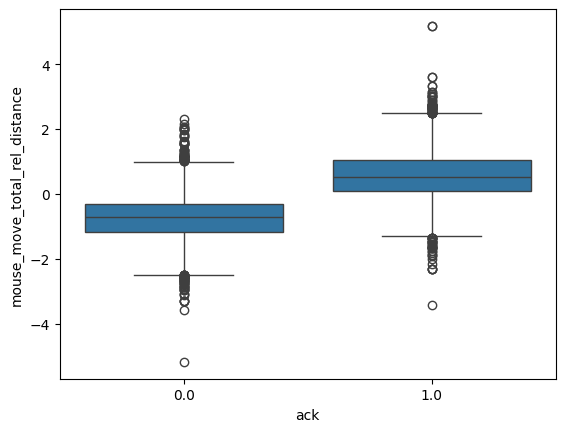

In [9]:
set_rule1(train_data,"train_rule1")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1226
           1       0.55      1.00      0.71      1500

    accuracy                           0.55      2726
   macro avg       0.28      0.50      0.35      2726
weighted avg       0.30      0.55      0.39      2726



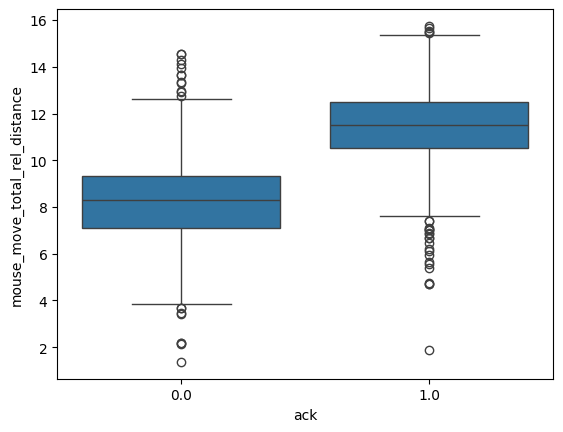

In [10]:
set_rule1(test_data,"test_rule1")

Vidíme, že máme vyššiu mieru accuracy a precision pre tréningový dataset.

# Pravidlo 2: (komplikovanejšie zahŕňajúce viacero atribútov)

Pre druhe pravidlo sme vybrali atribúty pct_scroll_move a pct_mouse_click, pretoze iny vysktli vo predoslej faze vo vysledkach recursive feature elimination. 
Ak je hodnota atribútu pct_scroll_move väčšia ako 0 a hodnota atribútu pct_mouse_click väčšia ako 1 tak bude  zaradený do skupinu, ktorá s väčšou pravdepodobnosťou kúpi.

In [11]:
def set_rule2(data, key):
    sns.scatterplot(y="pct_scroll_move", x="pct_mouse_click", hue="ack", data=data)

    temp = data[data['ack'].notna()]

    rules[key] = dict()
    rules[key]["total"] = temp['ack'].count()
    rules[key]["tp"] = len(temp.loc[((temp.pct_scroll_move > 0) & (temp.pct_mouse_click > 1)) & (temp['ack'] == 1.0), 'ack'])
    rules[key]["tn"] = len(temp.loc[((temp.pct_scroll_move <=0) | (temp.pct_mouse_click <= 1)) & (temp['ack'] == 0.0), 'ack'])
    rules[key]["fp"] = len(temp.loc[((temp.pct_scroll_move > 0) & (temp.pct_mouse_click > 1)) & (temp['ack'] == 0.0), 'ack'])
    rules[key]["fn"] = len(temp.loc[((temp.pct_scroll_move <= 0) | (temp.pct_mouse_click <= 1)) & (temp['ack'] == 1.0), 'ack'])

    print("\nTotal: ", rules[key]["total"])
    print("accuracy:  ",(rules[key]["tp"] + rules[key]["tn"]) / rules[key]["total"])
    print("precision:  ", rules[key]["tp"] / (rules[key]["fp"] + rules[key]["tp"]) + 1)
    print("recall:  ", rules[key]["tp"] / (rules[key]["fn"] + rules[key]["tp"]))

    rules[key]["values"] = np.array((temp.apply(
    lambda row: 1.0 if ((row.pct_scroll_move > 0) and (row.pct_mouse_click > 1)) else 0.0,axis=1)).values.tolist())
    rules[key]["cr"] = classification_report(temp['ack'], rules[key]["values"], target_names=["0", "1"])
    print(rules[key]["cr"])

Aplikujeme toto pravidlo na trénovací a testovací datasety a pozrieme na rozdiely výsledných hodnôt.


Total:  8175
accuracy:   0.5557186544342507
precision:   1.5557186544342507
recall:   1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3632
           1       0.56      1.00      0.71      4543

    accuracy                           0.56      8175
   macro avg       0.28      0.50      0.36      8175
weighted avg       0.31      0.56      0.40      8175



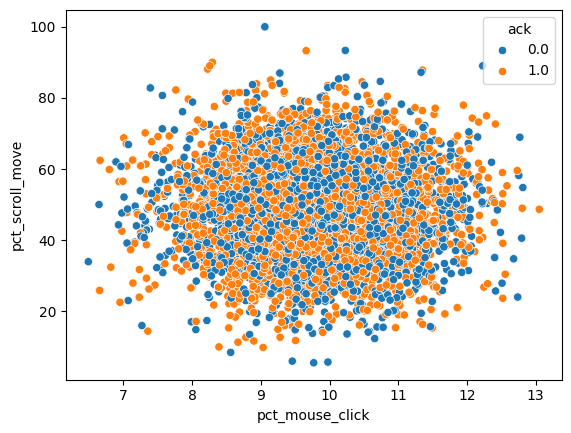

In [12]:
set_rule2(train_data,"train_rule2")


Total:  2726
accuracy:   0.5502567865003668
precision:   1.5502567865003667
recall:   1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1226
           1       0.55      1.00      0.71      1500

    accuracy                           0.55      2726
   macro avg       0.28      0.50      0.35      2726
weighted avg       0.30      0.55      0.39      2726



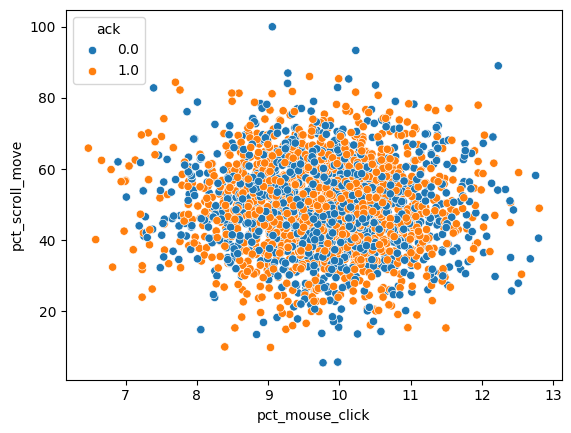

In [13]:
set_rule2(test_data,"test_rule2")

Vidíme, že mame accuracy a precision rates 0.55 ako aj v prvom pravidle.

# Trénovanie a vyhodnotenie klasifikátorov strojového učenia

Využívame DecisionTreeClassifier pre natrénovanie a vyhodnotenie klasifikátora, pretože sa používa na predpovedanie kategorických označení tried.

In [14]:
train_labels = train_data['ack']
test_labels = test_data['ack']
columns_to_exclude = ['ack']
train_features = train_data.drop(columns_to_exclude, axis=1)
test_features = test_data.drop(columns_to_exclude, axis=1)
clf = tree.DecisionTreeClassifier()
clf.fit(train_features, train_labels)
predicted_labels = clf.predict(test_features)

In [15]:
acc_r += accuracy_score(test_labels, predicted_labels)
pr_r += precision_score(test_labels, predicted_labels)
rec_r += recall_score(test_labels, predicted_labels)

In [16]:
print("Accuracy:", acc_r)
print("Precision:", pr_r)
print("Recall:", rec_r)

Accuracy: 0.9497432134996331
Precision: 0.893213054996331
Recall: 0.81305499633112


Vidime, ze metrics su väčší ako v oneR, lebo stromy sú vo všeobecnosti sofistikovanejšie a dokážu zachytiť zložité vzťahy v údajoch v porovnaní s jednoduchosťou pravidla One-R.

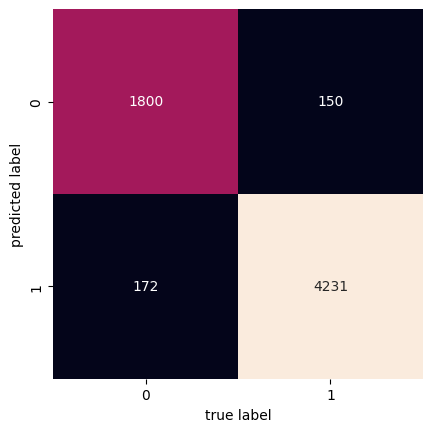

In [17]:
mat__values__range = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(mat__values_range, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Okrem toho sme vytvorili vizualizáciu pre naše pravidlá implementované v Decision Tree Classifier.

In [18]:
plt.figure(figsize=(80, 120))
plot_tree(clf, filled=True, feature_names=train_features.columns, class_names=["0", "1"], rounded=True, fontsize=10)
plt.show()

Sme sa rozhodli realizovať aj KNeighborsClassifier.

In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(train_features, train_labels)
predicted_labels = knn_classifier.predict(test_features)

In [20]:
acc_rate += accuracy_score(test_labels, predicted_labels)
pr_rate += precision_score(test_labels, predicted_labels)
rec_rate += recall_score(test_labels, predicted_labels)
print("Accuracy:", acc_rate)
print("Precision:", pr_rate)
print("Recall:", rec_rate)

Accuracy: 0.9517432134996331
Precision: 0.943213633105499
Recall: 0.963310549943213


Tam môžeme vidieť, že metriky ako v Decision Tree Classifier sú tiež vyššie ako v oneR, pretože ide o zložitejší prístup k analýze. Tiež si môžeme všimnúť, že výsledky KNeighborsClassifier sú o niečo lepšie v porovnaní s Decision Tree Classifier. Môže to byť spôsobené tým, že DecisionTreeClassifier je náchylný na overfitting, preto KNeighborsClassifier môže fungovať lepšie.